In [14]:
############# ANALYSIS PARAMETERS ##################################
FC_THRESH = 2.0    # fold-change threshold for filtering DE genes
DIRECTION = 'Down'   # 'Up' examines genes DE in Albany
GSEA_THRESH = 0.05 # FDR threshold for enriched gene sets
###################################################################

from os.path import join
import pandas as pd
from collections import defaultdict

RAW_DATA_LOC = '/Users/matthewbernstein/Development/covid_19_analysis/raw_data'
OUT_LOC = '/Users/matthewbernstein/Development/covid_19_analysis/compare_to_englert/results'
GENE_SETS = {
    'GO_molecular_function': 'gene_sets/c5.mf.v7.1.symbols.gmt',
    'GO_biological_process': 'gene_sets/c5.bp.v7.1.symbols.gmt',
    'MSigDB_Canonical_Pathways': 'gene_sets/c2.cp.v7.1.symbols.gmt',
    'MSigDB_Hallmark': 'gene_sets/h.all.v7.1.symbols.gmt'
}

de_genes_f = join(RAW_DATA_LOC, 'Albany_and_Englert/ebseq_males.ARDS.COVID.v.NO_HSCT/{}.Genes.pp99.txt'.format(DIRECTION))
ec_f = join(RAW_DATA_LOC, 'Albany_and_Englert/ebseq_males.ARDS.COVID.v.NO_HSCT/{}.Genes.pp99.Normed.tsv'.format(DIRECTION))
raw_f = join(RAW_DATA_LOC, 'AHNMJYDMXX_rsem/genes.tpm.no_hg.no_C054.tab')
eff_len_f = join(RAW_DATA_LOC, 'AHNMJYDMXX_rsem/median_effective_length.tsv')
symbol_f = join(RAW_DATA_LOC, 'AHNMJYDMXX_rsem/Symbol_ENSG.tsv')

out_f = join(OUT_LOC, 'englert_vs_albany_de/filter_DE_AE_11/male_only_ICU_COVID_VS_Englart_ARDS_{}_DE_GSEA.DE_AE_11.tsv'.format(DIRECTION))
out_kept_f = join(OUT_LOC, 'englert_vs_albany_de/filter_DE_AE_11/male_only_ICU_COVID_VS_Englart_ARDS_{}_DE.kept_genes.DE_AE_11.tsv'.format(DIRECTION))
out_venn_f = join(OUT_LOC, 'englert_vs_albany_de/filter_DE_AE_11/male_only_venn_{}.pd'.format(DIRECTION))
de_table_f = join(RAW_DATA_LOC, 'de_tables/{}.Genes.pp95.flags.tsv'.format(DIRECTION))
de_table_col = 'DE_AE_11'

Load the DE genes

In [15]:
with open(de_genes_f, 'r') as f:
    de_genes = [l.strip() for l in f]
print("{} total DE genes".format(len(de_genes)))

896 total DE genes


Load the set of all the genes from the original expression matrix

In [16]:
raw_df = pd.read_csv(raw_f, sep='\t', index_col=0)
all_genes = list(raw_df.index)
print('{} total genes'.format(len(all_genes)))

19462 total genes


Load the gene lengths

In [17]:
len_df = pd.read_csv(eff_len_f, sep='\t', index_col=0, header=None)
len_df = len_df.loc[all_genes]
gene_lens = list(len_df[1])
len_df

,1
0,
A1BG,3177.44
A1CF,8968.44
A2M,4245.44
A2ML1,4259.44
A3GALT2,818.44
...,...
ZYG11A,3488.44
ZYG11B,7938.44
ZYX,2019.96


Load gene symbol/ID data

In [18]:
symbol_df = pd.read_csv(symbol_f, sep='\t', index_col=0, header=None)
symbol_to_id = {
    sym: idd
    for sym, idd in zip(symbol_df.index, symbol_df[1])
}
symbol_to_id

{'A1BG': 'ENSG00000121410',
 'A1CF': 'ENSG00000148584',
 'A2M': 'ENSG00000175899',
 'A2ML1': 'ENSG00000166535',
 'A3GALT2': 'ENSG00000184389',
 'A4GALT': 'ENSG00000128274',
 'A4GNT': 'ENSG00000118017',
 'AAAS': 'ENSG00000094914',
 'AACS': 'ENSG00000081760',
 'AADAC': 'ENSG00000114771',
 'AADACL2': 'ENSG00000261846',
 'AADACL3': 'ENSG00000188984',
 'AADACL4': 'ENSG00000204518',
 'AADAT': 'ENSG00000109576',
 'AAGAB': 'ENSG00000103591',
 'AAK1': 'ENSG00000115977',
 'AAMDC': 'ENSG00000087884',
 'AAMP': 'ENSG00000127837',
 'AANAT': 'ENSG00000129673',
 'AAR2': 'ENSG00000131043',
 'AARD': 'ENSG00000205002',
 'AARS1': 'ENSG00000090861',
 'AARS2': 'ENSG00000124608',
 'AARSD1': 'ENSG00000266967',
 'AASDH': 'ENSG00000157426',
 'AASDHPPT': 'ENSG00000149313',
 'AASS': 'ENSG00000008311',
 'AATF': 'ENSG00000276072',
 'AATK': 'ENSG00000181409',
 'ABAT': 'ENSG00000183044',
 'ABCA1': 'ENSG00000165029',
 'ABCA10': 'ENSG00000154263',
 'ABCA12': 'ENSG00000144452',
 'ABCA13': 'ENSG00000179869',
 'ABCA2': 'E

 Map each gene to its fold change

In [19]:
ec_df = pd.read_csv(ec_f, sep='\t', index_col=0)
gene_to_fc = {
    gene: ec_df.loc[gene]['FC']
    for gene in ec_df.index
}
ec_df

,PP,C008,C010,C012,C014,C015,C020,C021,C022,C023,...,C099,C101,SRR3923733,SRR3923735,SRR3923736,SRR3923737,SRR3923738,SRR3923739,FC,L2FC
symbol,,,,,,,,,,,,,,,,,,,,,
ACKR1,1.00,0,4,4,3,0,4,3,5,5,...,2,0,82,18,120,112,53,216,0.05,-4.3
C4orf48,1.00,0,1,1,0,2,0,0,3,1,...,4,1,42,26,28,101,33,254,0.05,-4.4
CADM2,1.00,1,4,2,26,48,1,6,1,4,...,11,1,97,95,270,319,66,254,0.05,-4.3
ESPN,1.00,0,0,0,0,1,0,0,0,0,...,2,1,38,21,234,57,35,83,0.05,-4.2
GPR146,1.00,13,16,3,6,41,4,4,3,18,...,14,43,187,103,435,137,227,2664,0.05,-4.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF454,0.99,38,40,35,34,53,39,34,33,31,...,44,35,66,92,126,50,62,67,0.51,-1.0
ZFAT,0.99,170,159,200,198,240,277,164,133,202,...,137,117,204,288,349,360,237,368,0.58,-0.8
SQSTM1,0.99,3237,5034,3716,3898,2936,3397,4112,2577,2939,...,4516,3029,7095,8455,6157,6892,3636,7016,0.59,-0.8


Filter genes by fold-change

In [20]:
fold_filtered_genes = [
    gene
    for gene in gene_to_fc
    if gene_to_fc[gene] > FC_THRESH or gene_to_fc[gene] < (1/FC_THRESH)
]
print("{} genes with absolute fold-change > {}".format(
    len(fold_filtered_genes),
    FC_THRESH
))
ec_df.loc[fold_filtered_genes]

767 genes with absolute fold-change > 2.0


,PP,C008,C010,C012,C014,C015,C020,C021,C022,C023,...,C099,C101,SRR3923733,SRR3923735,SRR3923736,SRR3923737,SRR3923738,SRR3923739,FC,L2FC
symbol,,,,,,,,,,,,,,,,,,,,,
ACKR1,1.00,0,4,4,3,0,4,3,5,5,...,2,0,82,18,120,112,53,216,0.05,-4.3
C4orf48,1.00,0,1,1,0,2,0,0,3,1,...,4,1,42,26,28,101,33,254,0.05,-4.4
CADM2,1.00,1,4,2,26,48,1,6,1,4,...,11,1,97,95,270,319,66,254,0.05,-4.3
ESPN,1.00,0,0,0,0,1,0,0,0,0,...,2,1,38,21,234,57,35,83,0.05,-4.2
GPR146,1.00,13,16,3,6,41,4,4,3,18,...,14,43,187,103,435,137,227,2664,0.05,-4.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MROH1,0.99,97,250,119,103,87,75,57,34,87,...,198,145,292,282,256,643,386,578,0.35,-1.5
CYP2J2,0.99,1,1,1,4,4,1,1,0,0,...,1,3,13,10,9,17,9,5,0.36,-1.5
NAT8,0.99,0,2,1,0,0,0,0,1,2,...,1,1,0,25,1,0,0,0,0.40,-1.3


Load the DE flags table

In [21]:
de_table_df = pd.read_csv(de_table_f, sep='\t', index_col=0)
de_table_df

,DE_A_01,DE_A_02,DE_A_03,DE_A_04,DE_A_05,DE_A_06,DE_A_07,DE_A_08,DE_A_09,DE_E_01,...,DE_AE_04,DE_AE_05,DE_AE_06,DE_AE_07,DE_AE_08,DE_AE_09,DE_AE_10,DE_AE_11,DE_AE_12,DE_AE_13
symbol,,,,,,,,,,,,,,,,,,,,,
A1BG,1,0,0,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
A1CF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2M,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2ML1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A3GALT2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,1,0,0,0,0
ZYG11B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZYX,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,1,0,0,0,0


Select the likely batch effect genes

In [22]:
batch_effect_genes = frozenset(
    de_table_df.loc[de_table_df[de_table_col] == 1].index
)
print('{} total genes considered to be "batch-effect" genes'.format(len(batch_effect_genes)))

1054 total genes considered to be "batch-effect" genes


Remove the batch effect genes

In [23]:
removed_batch_effect_genes = batch_effect_genes & set(fold_filtered_genes)
print('Removed {} genes.'.format(
    len(removed_batch_effect_genes)
))
fold_batch_filtered_genes = sorted(set(fold_filtered_genes) - batch_effect_genes)
print('{}/{} remain after filtering by batch-effect:'.format(
    len(fold_batch_filtered_genes),
    len(gene_to_fc)
))

Removed 297 genes.
470/896 remain after filtering by batch-effect:


Plot the Venn diagram

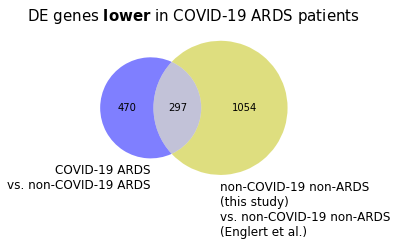

In [24]:
import matplotlib as mpl
from matplotlib_venn import venn2
from matplotlib import pyplot as plt
if 'Up' in de_genes_f:
    title = r'DE genes $\bf{higher}$ in COVID-19 ARDS patients'
else:
    title = r'DE genes $\bf{lower}$ in COVID-19 ARDS patients'
fig, ax = plt.subplots(1,1,figsize=(5.5,3.5))
venn2(
    subsets = (
        len(fold_batch_filtered_genes),
        len(batch_effect_genes),
        len(removed_batch_effect_genes),
    ),
    set_labels = (
        'COVID-19 ARDS\nvs. non-COVID-19 ARDS',
        'non-COVID-19 non-ARDS\n(this study)\nvs. non-COVID-19 non-ARDS\n(Englert et al.)'
    ),
    set_colors=('b', 'y'),
    alpha = 0.5,
    ax=ax
)
ax.set_title(title, fontsize=15)
fig.tight_layout()
plt.savefig(out_venn_f, format='pdf')
plt.show()

Perform gene set enrichment on filtered DE genes

In [25]:
import run_goseq

db_to_gene_sets = {}
missing_genes = set()
for db_name, db in GENE_SETS.items():
    print('Running GOseq for gene sets in {}...'.format(db))
    gene_set_to_genes = run_goseq._parse_gene_sets(db)
    
    # Map each gene to its gene sets
    gene_to_gene_sets = defaultdict(lambda: [])
    for gene_set, genes in gene_set_to_genes.items():
        for gene in genes:
            gene_to_gene_sets[gene].append(gene_set)
    gene_to_gene_sets = dict(gene_to_gene_sets)
    
    # Keep track of missing genes
    missing = set([x.strip() for x in gene_to_gene_sets.keys()]) - set(all_genes)
    missing_genes.update(missing)    

    # Remove genes from gene sets that aren't in our
    # dataset
    gene_to_gene_sets = {
        k: v
        for k,v in gene_to_gene_sets.items()
        if k in all_genes
    }
        
    df_goseq = run_goseq.run_GOseq(
        fold_batch_filtered_genes,
        all_genes,
        gene_to_gene_sets,
        gene_lens
    )
    df_goseq = df_goseq.loc[df_goseq['fdr'] < GSEA_THRESH]
    gene_set_to_pval = {
        gene_set: df_goseq.loc[gene_set]['fdr']
        for gene_set in df_goseq.index
    }
    db_to_gene_sets[db_name] = gene_set_to_pval

# Track the missing genes
with open('missing_genes.tsv', 'w') as f:
    f.write('\n'.join(sorted(missing_genes)))


Running GOseq for gene sets in gene_sets/c5.mf.v7.1.symbols.gmt...


R[write to console]: Using manually entered categories.

R[write to console]: For 4820 genes, we could not find any categories. These genes will be excluded.

R[write to console]: To force their use, please run with use_genes_without_cat=TRUE (see documentation).

R[write to console]: This was the default behavior for version 1.15.1 and earlier.

R[write to console]: Calculating the p-values...



Running GOseq for gene sets in gene_sets/c5.bp.v7.1.symbols.gmt...


R[write to console]: Using manually entered categories.

R[write to console]: For 3396 genes, we could not find any categories. These genes will be excluded.

R[write to console]: To force their use, please run with use_genes_without_cat=TRUE (see documentation).

R[write to console]: This was the default behavior for version 1.15.1 and earlier.

R[write to console]: Calculating the p-values...



Running GOseq for gene sets in gene_sets/c2.cp.v7.1.symbols.gmt...


R[write to console]: Using manually entered categories.

R[write to console]: For 7798 genes, we could not find any categories. These genes will be excluded.

R[write to console]: To force their use, please run with use_genes_without_cat=TRUE (see documentation).

R[write to console]: This was the default behavior for version 1.15.1 and earlier.

R[write to console]: Calculating the p-values...



Running GOseq for gene sets in gene_sets/h.all.v7.1.symbols.gmt...


R[write to console]: Using manually entered categories.

R[write to console]: For 15093 genes, we could not find any categories. These genes will be excluded.

R[write to console]: To force their use, please run with use_genes_without_cat=TRUE (see documentation).

R[write to console]: This was the default behavior for version 1.15.1 and earlier.

R[write to console]: Calculating the p-values...



Organize gene set enrichment results and write output to file

In [26]:
da = []
for db, gene_set_to_pval in db_to_gene_sets.items():
    for gene_set, pval in gene_set_to_pval.items():
        da.append((db, gene_set, pval))
df = pd.DataFrame(
    data=da,
    columns=['collection', 'gene_set', 'adjusted_p_value']
)
df = df.sort_values(by='adjusted_p_value', axis=0)
print('{} total enriched gene sets.'.format(len(df)))

# Write output
print('Writing to {}.'.format(out_f))
df.to_csv(out_f, index=False, sep='\t')
print('done')
df


64 total enriched gene sets.
Writing to /Users/matthewbernstein/Development/covid_19_analysis/compare_to_englert/results/englert_vs_albany_de/filter_DE_AE_11/male_only_ICU_COVID_VS_Englart_ARDS_Down_DE_GSEA.DE_AE_11.tsv.
done


,collection,gene_set,adjusted_p_value
62,MSigDB_Hallmark,HALLMARK_INTERFERON_ALPHA_RESPONSE,2.797789e-16
63,MSigDB_Hallmark,HALLMARK_INTERFERON_GAMMA_RESPONSE,1.741128e-13
17,MSigDB_Canonical_Pathways,REACTOME_INTERFERON_ALPHA_BETA_SIGNALING,5.451165e-07
0,GO_biological_process,GO_RESPONSE_TO_TYPE_I_INTERFERON,2.138898e-06
1,GO_biological_process,GO_NEGATIVE_REGULATION_OF_VIRAL_PROCESS,6.476440e-05
...,...,...,...
57,MSigDB_Canonical_Pathways,REACTOME_HCMV_LATE_EVENTS,3.358056e-02
58,MSigDB_Canonical_Pathways,REACTOME_ACTIVATION_OF_ANTERIOR_HOX_GENES_IN_H...,3.680002e-02
59,MSigDB_Canonical_Pathways,REACTOME_DNA_DAMAGE_TELOMERE_STRESS_INDUCED_SE...,3.836670e-02
60,MSigDB_Canonical_Pathways,REACTOME_REPRODUCTION,4.400963e-02
